In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import KFold, train_test_split

from lightgbm import LGBMRegressor
from lightgbm import early_stopping
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold

import optuna

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
sub = pd.read_csv('dataset/sample_submission.csv')

In [4]:
train.head(5)

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [9]:
test.head(5)

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


In [7]:
print("Shape of training data: ", train.shape)

Shape of training data:  (230130, 6)


In [8]:
print("Shape of testing data: ", test.shape)

Shape of testing data:  (98550, 5)


In [11]:
# Check for missing values with descending order (training data)
train.isnull().sum().sort_values(ascending=False)

num_sold    8871
id             0
date           0
country        0
store          0
product        0
dtype: int64

In [12]:
# Check for missing values with descending order (testing data)
test.isnull().sum().sort_values(ascending=False)

id         0
date       0
country    0
store      0
product    0
dtype: int64

In [13]:
# Check for feature types of training data
train.dtypes

id            int64
date         object
country      object
store        object
product      object
num_sold    float64
dtype: object

In [14]:
train.describe()

,id,num_sold
count,230130.000000,221259.000000
mean,115064.500000,752.527382
std,66432.953062,690.165445
min,0.000000,5.000000
25%,57532.250000,219.000000
50%,115064.500000,605.000000
75%,172596.750000,1114.000000
max,230129.000000,5939.000000


In [15]:
train.describe(include='object')

,date,country,store,product
count,230130,230130,230130,230130
unique,2557,6,3,5
top,2010-01-01,Canada,Discount Stickers,Holographic Goose
freq,90,38355,76710,46026


In [16]:
train['country'].value_counts()

country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64

In [17]:
train['store'].value_counts()

store
Discount Stickers       76710
Stickers for Less       76710
Premium Sticker Mart    76710
Name: count, dtype: int64

In [18]:
train['product'].value_counts()

product
Holographic Goose     46026
Kaggle                46026
Kaggle Tiers          46026
Kerneler              46026
Kerneler Dark Mode    46026
Name: count, dtype: int64

In [19]:
train = train.dropna()
test = test.dropna()

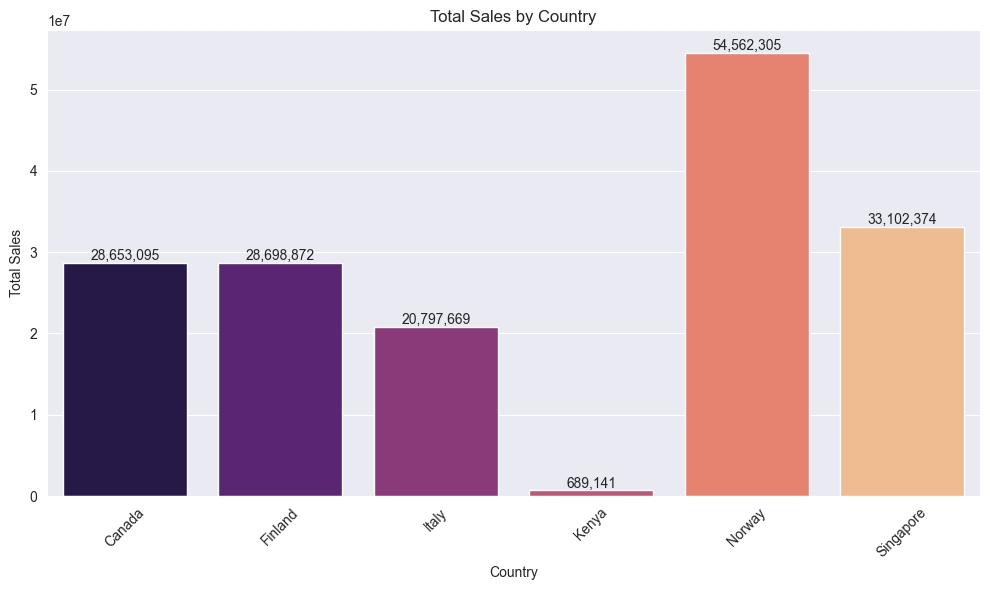

In [20]:
country_sales = train.groupby('country')['num_sold'].sum()

# Visualization
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=country_sales.index, y=country_sales.values, palette='magma')
plt.title("Total Sales by Country")
plt.xlabel("Country")
plt.ylabel("Total Sales")

# Adding values on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

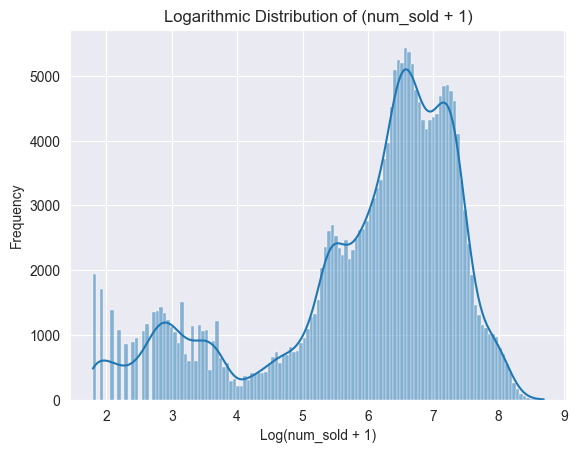

In [21]:
sns.histplot(data=train, x=np.log1p(train['num_sold']), kde=True)
plt.title("Logarithmic Distribution of (num_sold + 1)")
plt.xlabel("Log(num_sold + 1)")
plt.ylabel("Frequency")
plt.show()

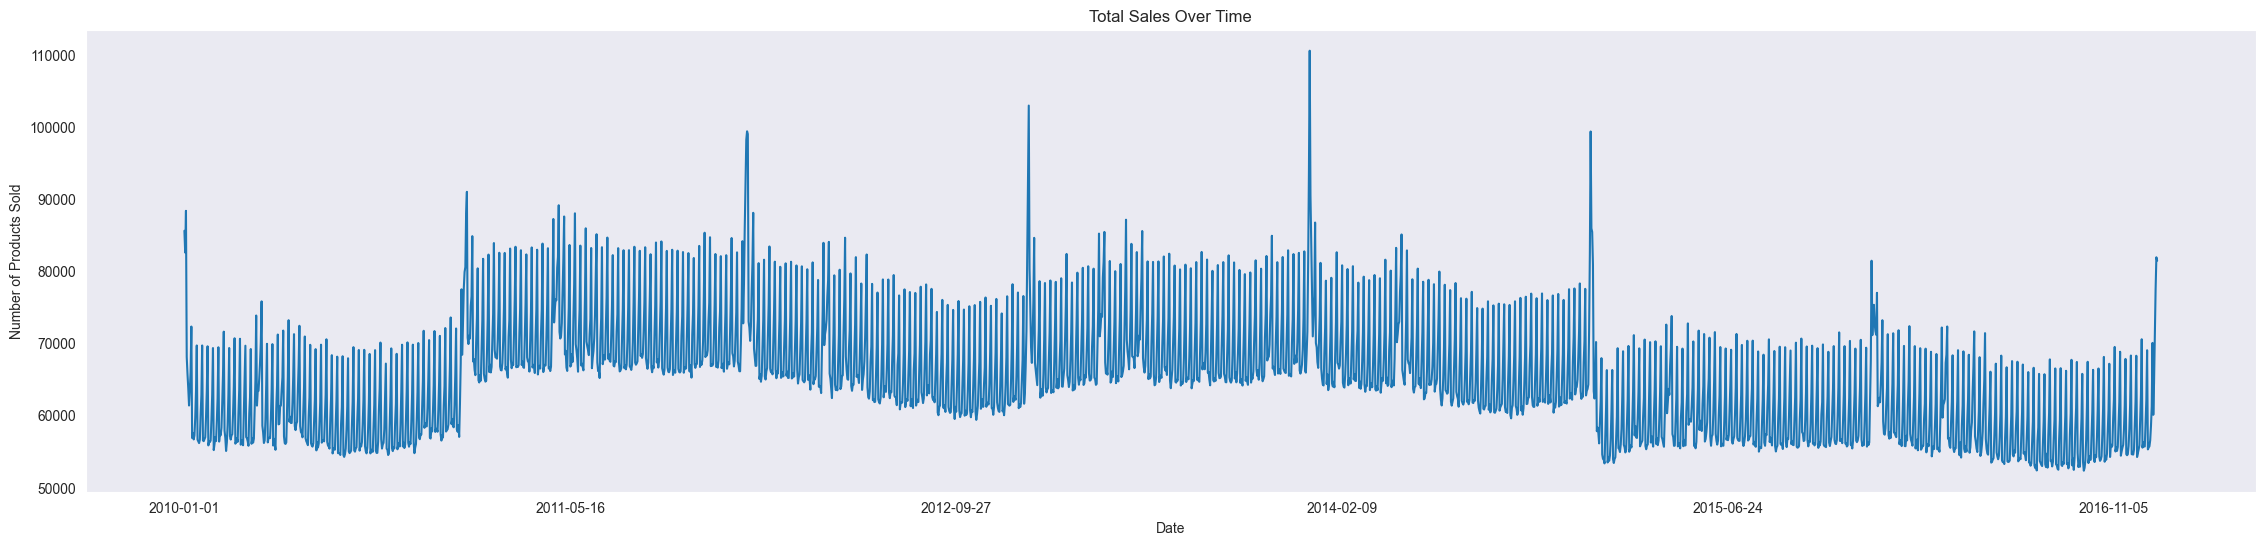

In [22]:
plt.figure(figsize=(28, 6))
train.groupby('date')['num_sold'].sum().plot(title='Total Sales Over Time', xlabel='Date', ylabel='Number of Products Sold')
plt.grid()
plt.show()

In [23]:
def transform_date(df, col):
    # Convert the column to datetime
    df[col] = pd.to_datetime(df[col])

    # Extract temporal features
    df[f'{col}_year'] = df[col].dt.year.astype('float64')
    df[f'{col}_quarter'] = df[col].dt.quarter.astype('float64')
    df[f'{col}_month'] = df[col].dt.month.astype('float64')
    df[f'{col}_day'] = df[col].dt.day.astype('float64')
    df[f'{col}_day_of_week'] = df[col].dt.dayofweek.astype('float64')
    df[f'{col}_week_of_year'] = df[col].dt.isocalendar().week.astype('float64')
    df[f'{col}_hour'] = df[col].dt.hour.astype('float64')
    df[f'{col}_minute'] = df[col].dt.minute.astype('float64')

    # Add cyclical encodings
    df[f'{col}_day_sin'] = np.sin(2 * np.pi * df[f'{col}_day'] / 365.0)
    df[f'{col}_day_cos'] = np.cos(2 * np.pi * df[f'{col}_day'] / 365.0)
    df[f'{col}_month_sin'] = np.sin(2 * np.pi * df[f'{col}_month'] / 12.0)
    df[f'{col}_month_cos'] = np.cos(2 * np.pi * df[f'{col}_month'] / 12.0)
    df[f'{col}_year_sin'] = np.sin(2 * np.pi * df[f'{col}_year'] / 7.0)
    df[f'{col}_year_cos'] = np.cos(2 * np.pi * df[f'{col}_year'] / 7.0)

    # Add group feature (for time-based grouping)
    df[f'{col}_Group'] = (df[f'{col}_year'] - 2010) * 48 + df[f'{col}_month'] * 4 + df[f'{col}_day'] // 7

    return df

In [24]:
new_train = transform_date(train, 'date')
new_test = transform_date(test, 'date')

In [25]:
new_train['num_sold'] = np.log1p(new_train['num_sold'])
new_train = new_train.drop(columns=['date', 'id'], axis=1)
new_test = new_test.drop(columns=['date', 'id'], axis=1)

In [26]:
num_cols = list(new_train.select_dtypes(exclude=['object']).columns.difference(['num_sold']))
cat_ftrs = list(new_train.select_dtypes(include=['object']).columns)

num_cols_test = list(new_test.select_dtypes(exclude=['object']).columns.difference(['id']))
cat_ftrs_test = list(new_test.select_dtypes(include=['object']).columns)

In [27]:

train_test_comb = pd.concat([new_train, new_test], axis=0, ignore_index=True)
for col in cat_ftrs:
    train_test_comb[col], _ = train_test_comb[col].factorize()
    train_test_comb[col] -= train_test_comb[col].min()
    # label encode to categorical and convert int32 to category
    train_test_comb[col] = train_test_comb[col].astype('int32')
    train_test_comb[col] = train_test_comb[col].astype('category')

for col in num_cols:
    if train_test_comb[col].dtype=='float64':
        train_test_comb[col].astype('float32')
    if train_test_comb[col].dtype=='int64':
        train_test_comb[col].astype('int32')

new_train = train_test_comb.iloc[:len(new_train)].copy()
new_test = train_test_comb.iloc[len(new_train):].copy()





In [28]:
new_test = new_test.drop(columns='num_sold', axis=1)

In [29]:
X= new_train.drop(columns=['num_sold'])
y = new_train['num_sold']

In [30]:
import lightgbm as lgb
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'mape',  # We'll evaluate on MAPE
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-4, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'random_state': 42,
        'verbose': -1,
        'device': 'cpu'
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_val)
    mape = mean_absolute_percentage_error(y_val, y_pred)
    return mape

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best parameters and MAPE
print("Best parameters:", study.best_params)
print("Best MAPE:", study.best_value)

[I 2025-01-13 00:20:47,973] A new study created in memory with name: no-name-c1a59105-2ae8-4b97-a1c0-e2ec8bb85624
[I 2025-01-13 00:20:49,362] Trial 0 finished with value: 0.008132700763142112 and parameters: {'n_estimators': 317, 'learning_rate': 0.1912367848837468, 'max_depth': 7, 'reg_alpha': 0.16750337821151892, 'lambda_l2': 0.0012115633682902981, 'min_child_samples': 57, 'colsample_bytree': 0.8811406782794484, 'subsample': 0.9947975553676187}. Best is trial 0 with value: 0.008132700763142112.
[I 2025-01-13 00:20:50,976] Trial 1 finished with value: 0.01110348835350399 and parameters: {'n_estimators': 373, 'learning_rate': 0.021233805184217584, 'max_depth': 5, 'reg_alpha': 0.008671323038530562, 'lambda_l2': 0.011313228950611744, 'min_child_samples': 28, 'colsample_bytree': 0.8233019815818616, 'subsample': 0.5020520563098275}. Best is trial 0 with value: 0.008132700763142112.
[I 2025-01-13 00:20:53,423] Trial 2 finished with value: 0.007931574748736108 and parameters: {'n_estimators'

Best parameters: {'n_estimators': 944, 'learning_rate': 0.15521901780322467, 'max_depth': 10, 'reg_alpha': 0.016867421265881026, 'lambda_l2': 0.20608372189787533, 'min_child_samples': 74, 'colsample_bytree': 0.6587188331251237, 'subsample': 0.6315990261552645}
Best MAPE: 0.007897493291046153


In [32]:
# Use the best parameters found by Optuna for final training and prediction
lgb_params = study.best_params
lgb_params.update({
    'device': 'cpu',                # Use GPU for training
    'n_jobs': -1,                   # Use all available CPU threads
})

# K-Fold Cross-validation with LightGBM
scores, lgb_test_preds = [], []

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_idx, val_idx) in enumerate(kfold.split(X)):
    print(f'Fold {i}')
    X_train_fold, X_val_fold = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Train the model with the best parameters
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    lgb_model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)])

    y_preds = lgb_model.predict(X_val_fold)
    mape_score = mean_absolute_percentage_error(y_val_fold, y_preds)
    print(f'MAPE Score for fold {i}:', mape_score)
    scores.append(mape_score)
    lgb_test_preds.append(lgb_model.predict(X))

# Calculate mean and std of MAPE
lgb_score = np.mean(scores)
lgb_std = np.std(scores)

print(f"Mean MAPE: {lgb_score}, Std MAPE: {lgb_std}")

Fold 0
[LightGBM] [Warning] lambda_l2 is set=0.20608372189787533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20608372189787533
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set=0.20608372189787533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20608372189787533
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 482
[LightGBM] [Info] Number of data points in the train set: 177007, number of used features: 16
[LightGBM] [Warning] lambda_l2 is set=0.20608372189787533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20608372189787533
[LightGBM] [Warning] Accuracy may be

In [33]:
sub['num_sold'] = np.expm1(lgb_model.predict(new_test))
sub.to_csv('submission.csv', index=False)
sub.head()

[LightGBM] [Warning] lambda_l2 is set=0.20608372189787533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20608372189787533
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,id,num_sold
0,230130,147.641578
1,230131,931.388202
2,230132,713.484154
3,230133,412.395315
4,230134,496.402266
